In [ ]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.decomposition import PCA
from sklearn.metrics import brier_score_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

from mifs import MutualInformationFeatureSelector
from collections import defaultdict

from math import isfinite

https://danielhomola.com/feature%20selection/phd/mifs-parallelized-mutual-information-based-feature-selection-module/#how-to-select-features-using-mutual-information

In [36]:
feat_selector = MutualInformationFeatureSelector(method='MRMR', n_features=60, categorical=False, n_jobs=-1)
feat_selector.fit(X_train, y_train)
X_selected = feat_selector.transform(X_train)

df_selector = pd.DataFrame({'feature': list(X_train.columns[feat_selector._support_mask]), 'ranking': feat_selector.ranking_})
print("Selected features:", list(X_train.columns[feat_selector._support_mask]))
print("Ranking:", feat_selector.ranking_)

Selected features: ['reach_blue', 'reach_red', 'reach_diff', 'age_diff', 'blue_age', 'red_age', 'height_blue', 'height_red', 'weight_class', 'total_bonus_red', 'total_bonus_blue', 'total_bonus_diff', 'reverse_pr_blue', 'reverse_pr_red', 'total_td_defended_diff', 'red_td_landed_total', 'blue_td_landed_total', 'red_td_defended_total', 'blue_td_defended_total', 'total_td_landed_diff', 'red_kd_total', 'blue_kd_total', 'kd_total_diff', 'math_red', 'math_blue', 'months_since_red', 'months_since_blue', 'months_since_diff', 'red_win_streak', 'red_lose_streak', 'blue_win_streak', 'blue_lose_streak', 'win_pct_red', 'win_pct_blue', 'num_fights_red', 'num_fights_blue', 'num_wins_red', 'num_wins_blue', 'num_losses_red', 'num_losses_blue', 'num_fights_diff', 'win_streak_diff', 'lose_streak_diff', 'wins_diff', 'losses_diff', 'decision_wins_red', 'ko_wins_red', 'sub_wins_red', 'decision_wins_blue', 'ko_wins_blue', 'sub_wins_blue', 'decision_wins_diff', 'ko_wins_diff', 'sub_wins_diff', 'open_blue', 'op

c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MutualInformationFeatureSelector was fitted without feature names
  warnings.warn(


In [ ]:
df_selector.sort_values(by='ranking').head(60)

Accuracy: 0.6617842876165113
Classification report:
               precision    recall  f1-score   support

         0.0       0.61      0.64      0.63       332
         1.0       0.70      0.68      0.69       419

    accuracy                           0.66       751
   macro avg       0.66      0.66      0.66       751
weighted avg       0.66      0.66      0.66       751



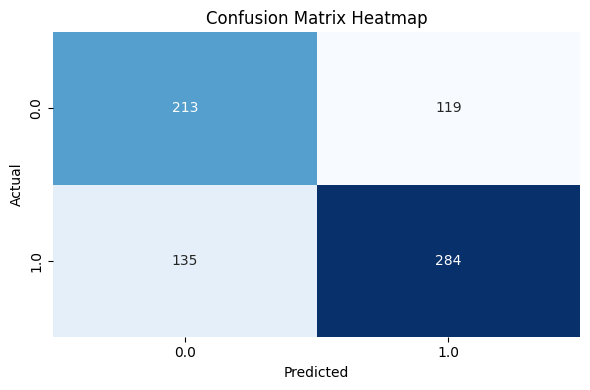

In [41]:
selected_columns = X_train.columns[feat_selector._support_mask]
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=9000)
clf.fit(X_train_selected, y_train)

# --- Step 5: Evaluate
y_pred = clf.predict(X_test_selected)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

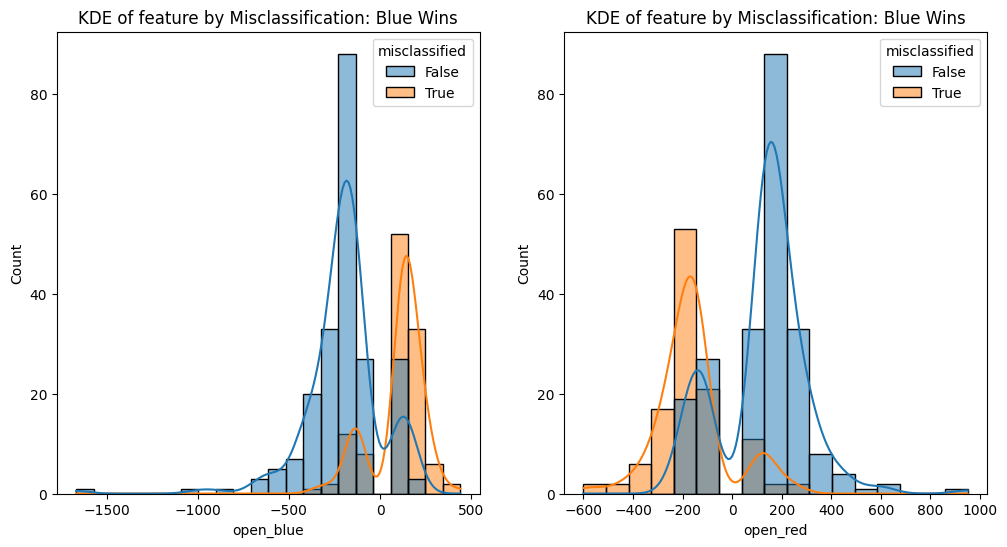

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [155]:
# Extract misclassified samples and their features
copy_df_test = copy_df.iloc[train_len:].reset_index(drop=True)
copy_df_test["true_label"] = y_test.values
copy_df_test["pred_label"] = y_pred
copy_df_test["misclassified"] = copy_df_test["true_label"] != copy_df_test["pred_label"]

df_blue_dog_wins = copy_df_test[(copy_df_test['winner']==0) & (copy_df_test['open_blue']> 0)]
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Example: KDE plot of one feature split by misclassification
plt.figure(figsize=(8, 6))
sns.histplot(
    data=copy_df_test[copy_df_test['winner']==0],
    x="open_blue",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[0]
)
axes[0].set_title("KDE of feature by Misclassification: Blue Wins")

# Example: KDE plot of one feature split by misclassification
plt.figure(figsize=(8, 6))
sns.histplot(
    data=copy_df_test[copy_df_test['winner']==0],
    x="open_red",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[1]
)
axes[1].set_title("KDE of feature by Misclassification: Blue Wins")
plt.tight_layout()
plt.show()

In [157]:
from sklearn.cluster import KMeans

# ---- Step 1: Cluster test data ----
# Exclude label/pred columns when clustering, just use features
feature_cols = X_test.columns
X_test_features = X_test[feature_cols]

# Fit k-means (choose k as you see fit)
kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(X_test_features)

# ---- Step 2: Add cluster + misclassified column ----
copy_df_test['cluster'] = cluster_labels

# ---- Step 3: Compute per-cluster accuracy ----
cluster_stats = (
    copy_df_test
    .groupby('cluster')
    .agg(
        total_points=('misclassified', 'size'),
        misclassified=('misclassified', 'sum')
    )
)

cluster_stats['accuracy'] = 1 - (cluster_stats['misclassified'] / cluster_stats['total_points'])
cluster_stats.reset_index(inplace=True)

print(cluster_stats)

   cluster  total_points  misclassified  accuracy
0        0           140             49  0.650000
1        1           124             48  0.612903
2        2            92             39  0.576087
3        3           122             42  0.655738
4        4            63             22  0.650794
5        5           105             31  0.704762
6        6           105             23  0.780952


In [159]:
df_bad = copy_df_test[(copy_df_test['cluster']==1) | (copy_df_test['cluster']==2)]
df_bad.head(10)

,date,winner,red_fighter,blue_fighter,reach_blue,reach_red,reach_diff,age_diff,blue_age,red_age,...,probs_fair_close1_blue,probs_fair_close2_blue,red_fav_counts,red_dog_counts,blue_fav_counts,blue_dog_counts,true_label,pred_label,misclassified,cluster
2,2023-08-12,0,polyana viana,iasmin lucindo,66.0,67.0,1.0,10.0,23.0,33.0,...,0.632353,0.638009,4,3,2,0,0.0,0,False,1
3,2023-08-12,1,khalil rountree jr,chris daukaus,76.0,76.0,0.0,-1.0,36.0,35.0,...,0.384615,0.370370,3,1,3,4,1.0,1,False,2
8,2023-08-19,1,karine silva,maryna moroz,67.0,67.0,0.0,-2.0,34.0,32.0,...,0.454493,0.451423,1,0,3,4,1.0,0,True,1
9,2023-08-19,0,andrea lee,natalia silva,65.0,69.0,4.0,8.0,28.0,36.0,...,0.731468,0.741445,5,4,2,0,0.0,0,False,1
16,2023-08-19,1,zhang weili,amanda lemos,65.0,63.0,-2.0,-2.0,38.0,36.0,...,0.268657,0.260731,3,1,1,5,1.0,1,False,1
17,2023-08-19,0,aljamain sterling,sean omalley,72.0,71.0,-1.0,5.0,31.0,36.0,...,0.319829,0.299864,10,8,6,3,0.0,1,True,2
20,2023-08-26,0,liang na,jj aldrich,67.0,67.0,0.0,-4.0,33.0,29.0,...,0.804544,0.820896,0,2,4,5,0.0,0,False,1
24,2023-08-26,1,erin blanchfield,taila santos,68.0,66.0,-2.0,-6.0,32.0,26.0,...,0.419255,0.404858,4,1,2,3,1.0,1,False,1
31,2023-09-02,1,manon fiorot,rose namajunas,65.0,65.0,0.0,2.0,33.0,35.0,...,0.375000,0.363289,2,0,5,5,1.0,0,True,1
40,2023-09-16,1,tracy cortez,jasmine jasudavicius,68.0,65.0,-3.0,-4.0,36.0,32.0,...,0.473043,0.468012,3,0,0,2,1.0,0,True,1


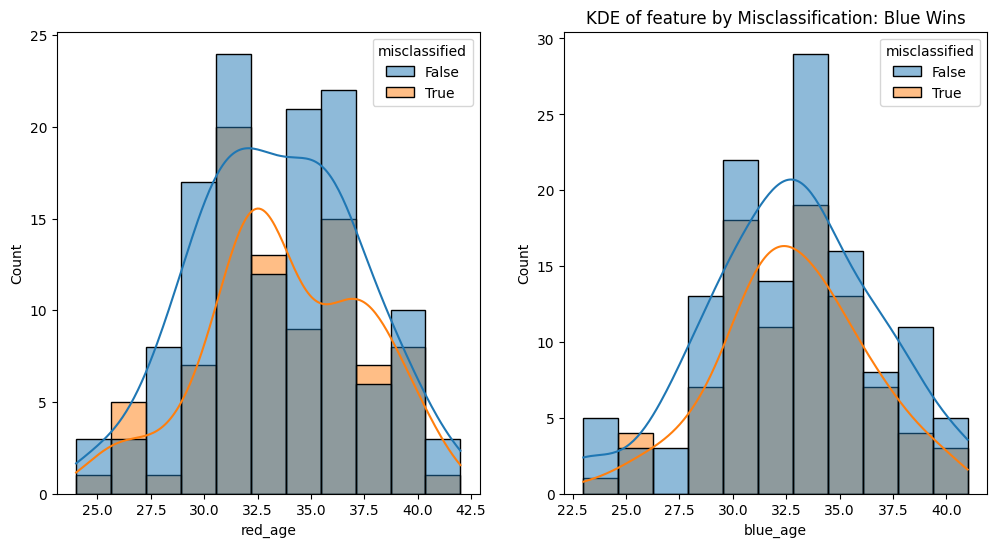

<Figure size 800x600 with 0 Axes>

In [163]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Example: KDE plot of one feature split by misclassification
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_bad,
    x="red_age",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[0]
)

sns.histplot(
    data=df_bad,
    x="blue_age",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[1]
)
axes[1].set_title("KDE of feature by Misclassification: Blue Wins")
plt.tight_layout()
plt.show()

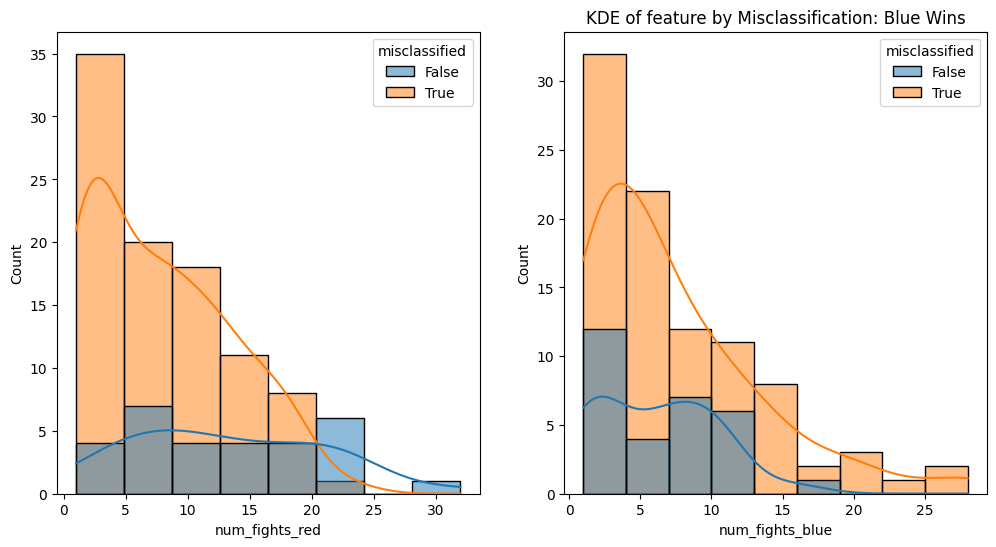

<Figure size 800x600 with 0 Axes>

In [152]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Example: KDE plot of one feature split by misclassification
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_blue_dog_wins,
    x="num_fights_red",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[0]
)

sns.histplot(
    data=df_blue_dog_wins,
    x="num_fights_blue",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[1]
)
axes[1].set_title("KDE of feature by Misclassification: Blue Wins")
plt.tight_layout()
plt.show()


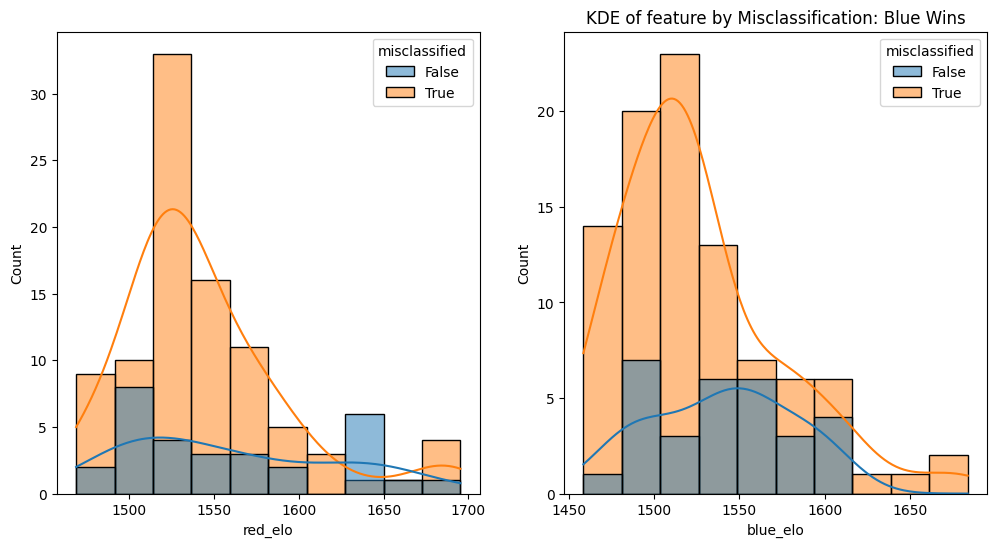

<Figure size 800x600 with 0 Axes>

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Example: KDE plot of one feature split by misclassification
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_blue_dog_wins,
    x="red_elo",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[0]
)

sns.histplot(
    data=df_blue_dog_wins,
    x="blue_elo",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[1]
)
axes[1].set_title("KDE of feature by Misclassification: Blue Wins")
plt.tight_layout()
plt.show()


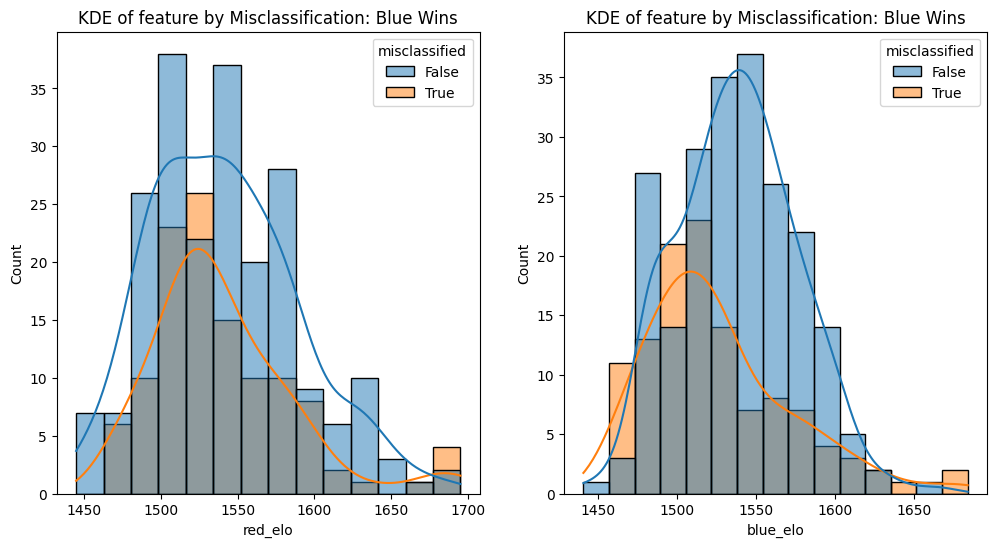

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

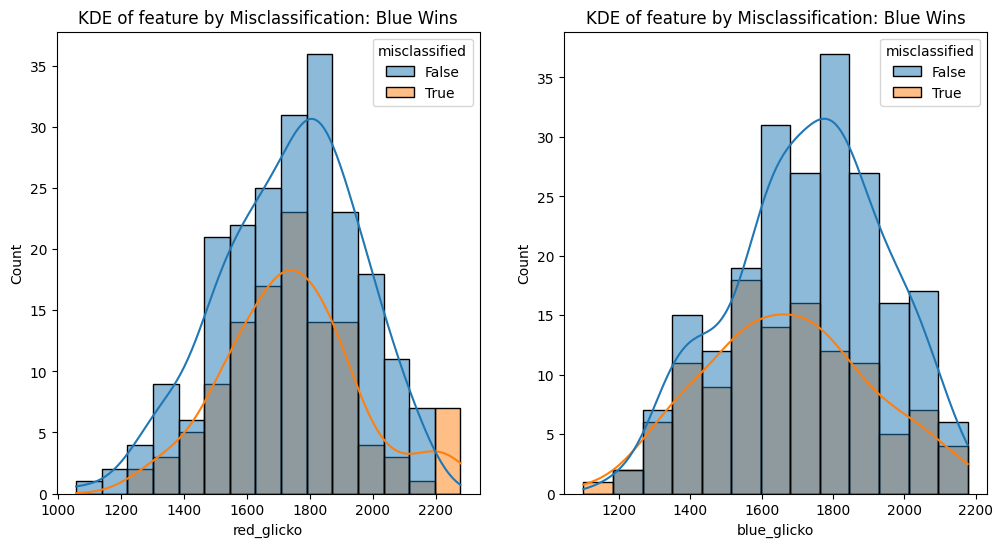

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Example: KDE plot of one feature split by misclassification
plt.figure(figsize=(8, 6))
sns.histplot(
    data=copy_df_test[copy_df_test['winner']==0],
    x="red_elo",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[0]
)
axes[0].set_title("KDE of feature by Misclassification: Blue Wins")

# Example: KDE plot of one feature split by misclassification
sns.histplot(
    data=copy_df_test[copy_df_test['winner']==0],
    x="blue_elo",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[1]
)
axes[1].set_title("KDE of feature by Misclassification: Blue Wins")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Example: KDE plot of one feature split by misclassification
sns.histplot(
    data=copy_df_test[copy_df_test['winner']==0],
    x="red_glicko",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[0]
)
axes[0].set_title("KDE of feature by Misclassification: Blue Wins")

# Example: KDE plot of one feature split by misclassification
plt.figure(figsize=(8, 6))
sns.histplot(
    data=copy_df_test[copy_df_test['winner']==0],
    x="blue_glicko",   # replace with your feature of interest
    hue="misclassified",
    common_norm=False,
    kde=True, 
    fill=True,
    ax=axes[1]
)
axes[1].set_title("KDE of feature by Misclassification: Blue Wins")
plt.tight_layout()
plt.show()